#**Brain Tumor Detection from MRI Images using CNN and Implementing SmoothGrad for Explainability**





# **Introduction**

Brain tumors are life-threatening and early detection is critical. This project aims to build a deep learning model using MRI scans to classify whether a patient has a tumor or not.


# **Problem Statement**

Given a dataset of labeled brain MRI images, the goal is to build a model that can accurately classify the images into:
- Tumor
- No Tumor

I have made this project keeping in mind that tumors during early stage are very small and cannot be easilty detected by naked eye or may be missed out by physicians. An Impoved version of this can be used as a second opnion for doctors as it is trained on pixels and it can detect any small chnages too.

#**Dataset**

- Source: [Kaggle - Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)
- Format: JPEG MRI scans
- Classes: 'yes' (tumor), 'no' (no tumor)
- Size: 253 images total

Due to the small size of the dataset I have decided to use a pre trianed model trained on RadImageNET images that is a specific dataset consisting of radiological images. Besides that I have also used **Image Augmentation** to increase the number of images to train on.


#Installing Necessary Libraries

In [ ]:
!pip install tensorflow
!pip install opencv
!pip install tf-keras-vis


ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.1 MB/s eta 0:00:00


#Importing Necessary Libraries

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import cv2, os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model
import zipfile
import os
from PIL import Image

#EDA

In [ ]:
zip_ref = zipfile.ZipFile('/content/archive (2).zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import shutil

shutil.rmtree('yes')
shutil.rmtree('no')

253
155
98


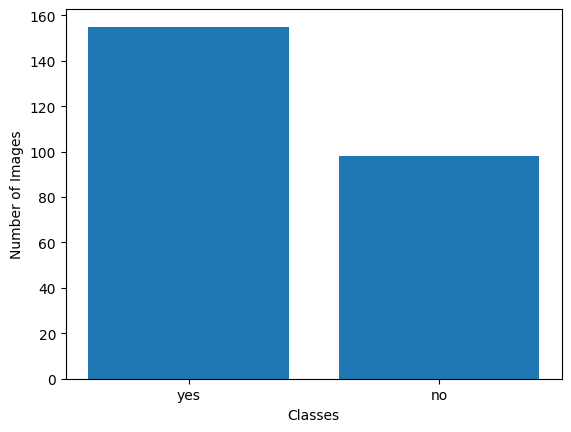

In [ ]:
classes={'yes':0,'no':0}
for filename in os.listdir('/content/brain_tumor_dataset'):
  for file in os.listdir('/content/brain_tumor_dataset/'+filename):
    classes[filename]+=1

# Class Imbalance
plt.bar(classes.keys(),classes.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.plot()

print(classes['yes']+classes['no'])
print(classes['yes'])
print(classes['no'])

The dataset shows class imbalance. To mitigate its effect, I applied class weights during model training to ensure both classes were fairly represented in the loss function.

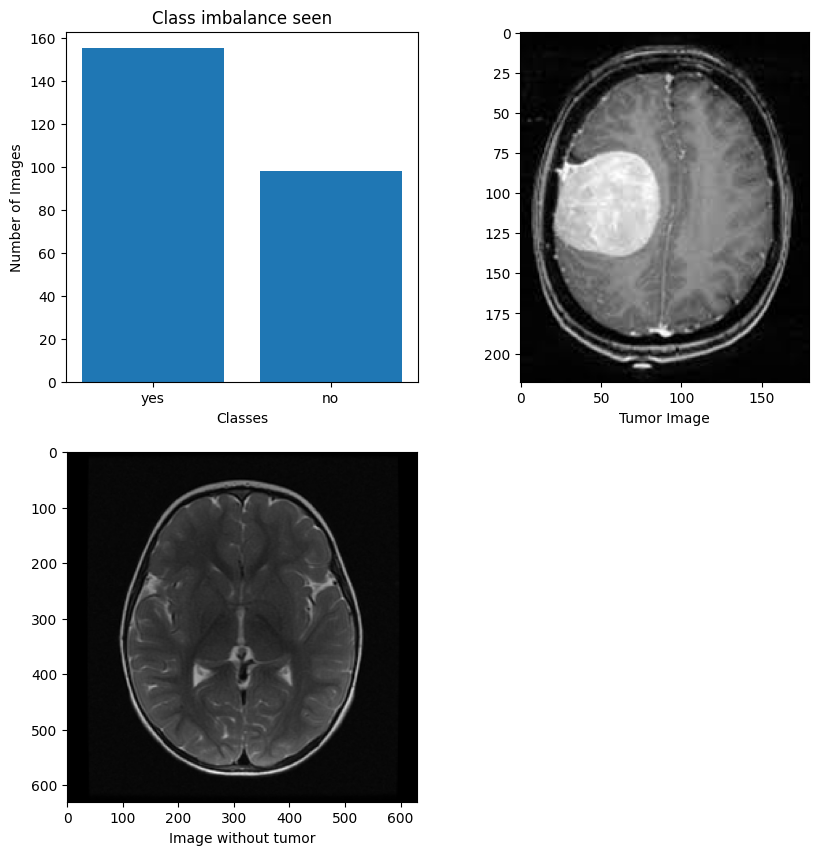

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.bar(classes.keys(),classes.values())
plt.xlabel('Classes')
plt.title("Class imbalance seen")
plt.ylabel('Number of Images')
plt.subplot(2,2,2)
plt.imshow(plt.imread('/content/brain_tumor_dataset/yes/Y1.jpg'))
plt.xlabel("Tumor Image")
plt.subplot(2,2,3)
plt.imshow(plt.imread('/content/brain_tumor_dataset/no/2 no.jpeg'))
plt.xlabel('Image without tumor')
plt.show()

#Data Preprocessing

Arranging the data in a speicfic format for the ImageDataGenerator to use. The format is:

```
Brain_Tumor_Detection_Project/
├── train/
│   ├── yes/
│   └── no/
├── test/
│   ├── yes/
│   └── no/
├── validation/
│   ├── yes/
│   └── no/
├── model/
│   └── resnet50_model.h5
└── Brain_Tumor_MRI_Images.ipynb

```
I used Keras' ImageDataGenerator to efficiently load and preprocess the images. The generator automatically reads images from the directory and infers the class labels based on the subfolder names (yes and no) inside each main folder (train, test, and validation).

This eliminates the need for manual label assignment and simplifies the data pipeline by organizing the dataset in a structured, hierarchical format.






No. of Images: 155
No. of Images: 98
[<PIL.Image.Image image mode=RGB size=273x351 at 0x7EEFA82A7CD0>, <PIL.Image.Image image mode=RGB size=250x290 at 0x7EEFA5BC8F90>, <PIL.Image.Image image mode=RGB size=264x338 at 0x7EEFA5B94ED0>, <PIL.Image.Image image mode=RGB size=311x355 at 0x7EEFA5BC9B50>, <PIL.Image.Image image mode=RGB size=244x308 at 0x7EEFA5BC97D0>, <PIL.Image.Image image mode=RGB size=231x283 at 0x7EEFA5631E10>, <PIL.Image.Image image mode=RGB size=526x555 at 0x7EEFA56328D0>, <PIL.Image.Image image mode=RGB size=355x450 at 0x7EEFA5BFB390>, <PIL.Image.Image image mode=RGB size=700x890 at 0x7EEFA5BAEF90>, <PIL.Image.Image image mode=RGB size=211x239 at 0x7EEFA5BFA010>, <PIL.Image.Image image mode=RGB size=223x303 at 0x7EEFA5BFAC10>, <PIL.Image.Image image mode=RGB size=314x340 at 0x7EEFA5BF9C50>, <PIL.Image.Image image mode=RGB size=225x225 at 0x7EEFA5BF8790>, <PIL.Image.Image image mode=RGB size=258x279 at 0x7EEFA5BF9E50>, <PIL.Image.Image image mode=RGB size=310x380 at 0x7E

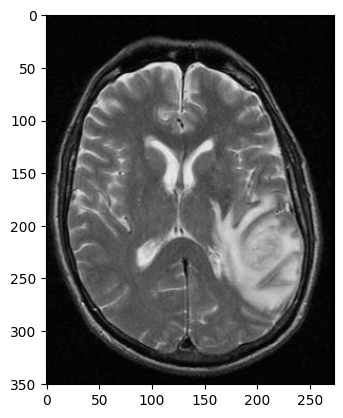

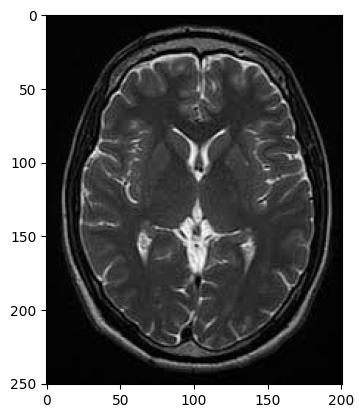

(251, 201, 3)


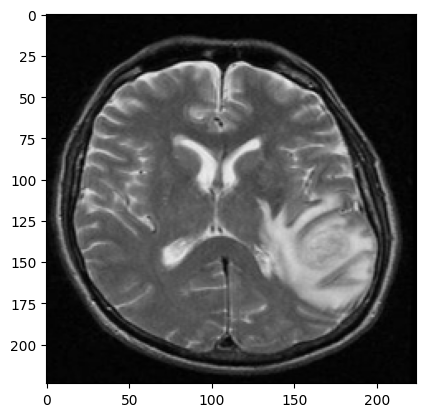

In [ ]:
def Input(input_directory):
  image_list=[]
  c=0
  for filename in os.listdir(input_directory):
    file_path = os.path.join(input_directory, filename)
    with Image.open(file_path) as img:
      img=img.convert("RGB")
      image_list.append(img.copy())
    c=c+1
  print("No. of Images:",c)
  return image_list

images_class_yes=Input('/content/brain_tumor_dataset/yes')
images_class_no=Input('/content/brain_tumor_dataset/no')

print(images_class_yes)

#Printing Random Images
plt.imshow(images_class_yes[0])
plt.show()
plt.imshow(images_class_no[0])
plt.show()

#Cheking the resized images
img=images_class_yes[0].resize(((224,224)))
plt.imshow(img)


print(np.array(images_class_no[0]).shape)

Splitting the images into test and train.

In [ ]:
from sklearn.model_selection import train_test_split
images_class_yes_train, images_class_yes_test = train_test_split(images_class_yes, test_size=0.2, random_state=42)
images_class_no_train, images_class_no_test = train_test_split(images_class_no, test_size=0.2, random_state=42)

print(len(images_class_yes_train))
print(len(images_class_yes_test))
print(len(images_class_no_train))
print(len(images_class_no_test))

124
31
78
20


Making folders for Train and Test and inside each there will be yes and no folders containing images.

In [ ]:
os.makedirs('/content/train/yes')
os.makedirs('/content/train/no')
os.makedirs('/content/test/yes')
os.makedirs('/content/test/no')

for i in images_class_yes_train:
  img=i
  img.save('/content/train/yes/'+str(images_class_yes_train.index(i))+'.jpg')

for i in images_class_no_train:
  img=i
  img.convert("RGB").save('/content/train/no/'+str(images_class_no_train.index(i))+'.jpg')

for i in images_class_yes_test:
  img=i
  img.save('/content/test/yes/'+str(images_class_yes_test.index(i))+'.jpg')

for i in images_class_no_test:
  img=i
  img.convert("RGB").save('/content/test/no/'+str(images_class_no_test.index(i))+'.jpg')


Creating validation dataset from the train set

In [ ]:
X,images_val_yes=train_test_split(images_class_yes_train, test_size=0.1, random_state=42)    #Generating validation Data
X,images_val_no=train_test_split(images_class_no_train, test_size=0.1, random_state=42)

print(len(images_val_yes))
print(len(images_val_no))

13
8


Making the folder structure using validation dataset

In [ ]:
os.makedirs('/content/validation/yes')
os.makedirs('/content/validation/no')

for i in images_val_yes:
  img=i
  img.save('/content/validation/yes/'+str(images_val_yes.index(i))+'.jpg')

for i in images_val_no:
  img=i
  img.convert("RGB").save('/content/validation/no/'+str(images_val_no.index(i))+'.jpg')

Initialising the ImageDataGenerator and defined how much random chnages can be done to create augmentated images.


```
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,   
    height_shift_range=0.2,    
    shear_range=0.3,          
    zoom_range=0.3,            
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'        
)
```

* **Rescale**: Divides each pixel value in the images by 255 to make it in the rage of 0 to 1

* **Rotation Range**: Randomly rotates the image within a range of ±40 degrees. This helps the model learn rotational invariance.

* **width_shift_range** : Shifts the image horizontally by up to 20% of the width. Useful for learning object positioning variance.

* **height_shift_range**: Shifts the image vertically by up to 20% of the height. Helps in learning patterns that may appear at different vertical locations.

* **zoom_range**: Randomly zooms in or out on images by up to 30%. Helps model learn to detect features at multiple scales.

* **horizontal_flip**:Randomly flips images horizontally.

* **vertical_flip**: Randomly flips images vertically (top ↕ bottom). Adds further variation, although not always realistic for medical images.

* **brightness_range**: Randomly adjusts brightness in the range from 50% to 150% of the original. Useful for simulating variations in image intensity.

* **fill_mode='nearest'**: When pixels are created (due to shifts/rotations), they are filled in using the value of the nearest pixel. Prevents artifacts from showing up in transformed images.







```
test_generator= test_datagen.flow_from_directory('/content/test',target_size=(224,224),batch_size=32,class_mode='binary')

train_generator=train_datagen.flow_from_directory('/content/train',target_size=(224,224),batch_size=32,class_mode='binary')

validation_generator=test_datagen.flow_from_directory('/content/validation',target_size=(224,224),batch_size=32,class_mode='binary')
```
Here I have specified the folder from which the ImageDataGenerator will takes the images to augment them to create more images.


*  **test_genrator** will create the images and supply the
augmented images for testing.

*  **train_generator** will create the images from the train folder and supply the augmented images for training.

* **validation_generator** will create images from the validation folder to supply images for the vlidation set during training.


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator= test_datagen.flow_from_directory('/content/test',target_size=(224,224),batch_size=32,class_mode='binary')

train_generator=train_datagen.flow_from_directory('/content/train',target_size=(224,224),batch_size=32,class_mode='binary')

validation_generator=test_datagen.flow_from_directory('/content/validation',target_size=(224,224),batch_size=32,class_mode='binary')

Found 50 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


```
Found 51 images belonging to 2 classes. # From test folder
Found 181 images belonging to 2 classes. # From training folder
Found 21 images belonging to 2 classes. # From validation folder
```
Here the **ImageDataGenerator** has automatically detected the classes and also gves us the number of images it got from the folders.

In [ ]:
from sklearn.utils import class_weight

labels=train_generator.classes

class_weights=class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
print(class_weights)
class_weights=dict(enumerate(class_weights))
print("Class Weights:", class_weights)

[1.29577465 0.81415929]
Class Weights: {0: np.float64(1.295774647887324), 1: np.float64(0.8141592920353983)}


I have used class weights to counter the effect of class imbalance.

This basically makes the mistake wrt the minority class more costly than the majority class.

#Model Building

I used a pretrained ResNet-50 model from RadImageNet, a large-scale dataset containing radiological images like CT, MRI, and X-rays. This model was specifically trained on medical images, making it far more suitable for my MRI brain tumor classification task than models trained on natural images like ImageNet.

The version I used includes only the convolutional base for feature extraction without dense layers, allowing me to customize the classifier for my specific binary classification task.

Among the available pretrained models from RadImageNet — ResNet-50, DenseNet, and InceptionNet . I chose ResNet-50 because:

*  **InceptionNet** is overly complex and prone to overfitting for small datasets.
*   While **DenseNet** performs well, ResNet-50 is more computationally efficient and better suited for generalization on small datasets.


While DenseNet performs well, ResNet-50 is more computationally efficient and better suited for generalization on small datasets.

Therefore, ResNet-50 offered the best trade-off between depth, performance, and computational simplicity for my use case.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/RadImageNet-ResNet50_notop.h5'

In [ ]:
convo_base = load_model(model_path)
convo_base.trainable = False

In [ ]:
convo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_2[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Intial pretrained weights of **ResNET50** that were from pretraning on the RadImageNET dataset.

In [ ]:
convo_base.weights

[<Variable path=conv1_conv/kernel, shape=(7, 7, 3, 64), dtype=float32, value=[[[[ 2.88208157e-01 -2.73274798e-02  2.67351419e-02 ... -6.55488670e-02
      5.03475368e-02 -4.56515253e-02]
    [ 1.99836820e-01 -1.79780759e-02 -3.68159488e-02 ...  1.49137285e-02
     -5.86674325e-02 -9.20280740e-02]
    [ 1.63633555e-01  2.29261611e-02  2.22781431e-02 ...  3.69511321e-02
     -5.65400533e-02 -7.73568973e-02]]
 
   [[ 2.48182908e-01 -1.27168700e-01  1.82238910e-02 ... -1.47653431e-01
      8.14998075e-02  6.49594814e-02]
    [ 1.69302464e-01 -6.09455369e-02 -1.79350842e-02 ... -9.85311568e-02
      1.47271249e-02 -1.64240897e-02]
    [ 6.12137169e-02 -2.44877376e-02 -5.26773743e-02 ... -5.27572297e-02
     -2.20677052e-02 -9.09108389e-03]]
 
   [[ 3.36220503e-01 -1.08493298e-01  8.58195052e-02 ... -1.58807382e-01
     -3.43158878e-02  9.48826075e-02]
    [ 1.79538935e-01 -1.01994433e-01  3.52014962e-04 ... -3.03748231e-02
     -1.56537712e-01  9.93644074e-02]
    [ 1.46763682e-01 -5.797271

In my training, I have first trained the model in two steps. The steps are:


*   Traning the Dense Layer that I added.
*   Fine tuning the pre trained weigths of the model.

In my first training step, I have trained the dense layer which freezing the colvolution layers to learn about the fatures extracted by the convolution layer with pretrained weights and to learn the weights of the dense layers.

In the second traning step, I have fine tuned the model by unfreezing some of the convolution layers and using a very low leanrng rate of 1e-6 to tune the covolution layers to extract the features in related to the brain MRI images.

**In first few trail tranings I saw that the model was learning features of the brain other than the tumor itself so I thought that it might be overfitting sue to less data so I added regularisation to couter the overfitting.**


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras import regularizers

print(convo_base.layers[-1])

inputs = Input(shape=(224, 224, 3))
x = convo_base(inputs, training=False)
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(128, kernel_regularizer=regularizers.l2(0.005), use_bias=True)(x1)
x2_bn = BatchNormalization()(x2)
x2_relu = Activation('relu')(x2_bn)
x3 = Dropout(0.3)(x2_relu)
outputs = Dense(1, activation='sigmoid')(x3)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<Activation name=conv5_block3_out, built=True>


In [ ]:
model.build(input_shape=(None, 224, 224, 3))

My Model summary for the first training step




In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Freezing the convolution layers for the first step of my training.

In [ ]:
for layer in convo_base.layers:
    layer.trainable = False

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

The training step.

In this the **train generator** takes images from the directory **/content/train** already given to it and augment the images and send to the model to learn from the images.



```
history=model.fit(train_generator,epochs=25,steps_per_epoch=50,validation_data=validation_generator,class_weight=class_weights)
```
This line means that there will be 25 epochs and in each epoch there will be 50 batches of 32 images for training.





In [ ]:
history=model.fit(train_generator,epochs=25,steps_per_epoch=50,validation_data=validation_generator,class_weight=class_weights)

Epoch 1/25
 6/50 ━━━━━━━━━━━━━━━━━━━━ 39s 893ms/step - accuracy: 0.6203 - loss: 1.9159

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 0.6292 - loss: 1.9267 - val_accuracy: 0.6190 - val_loss: 1.7311
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.7489 - loss: 1.7406 - val_accuracy: 0.6190 - val_loss: 1.6844
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6962 - loss: 1.6554 - val_accuracy: 0.6667 - val_loss: 1.5990
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7153 - loss: 1.5672 - val_accuracy: 0.7143 - val_loss: 1.5208
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.7242 - loss: 1.5272 - val_accuracy: 0.7143 - val_loss: 1.4357
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7426 - loss: 1.4292 - val_accuracy: 0.7619 - val_loss: 1.3537
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7372 - loss: 1.3271 - val_accuracy: 0.8095 - val_loss: 1.3193
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.7301 - loss: 1.3078 - val_accuracy: 0.8095 - val_loss: 

Converting the freezed layers in the **convo_base** , my base model to trainable layers.

In [ ]:
unfreeze_from_layer_name='conv4_block1_1_conv'

set_trainable=False
for layer in convo_base.layers:
    if layer.name==unfreeze_from_layer_name:
        set_trainable=True
    if set_trainable:
        layer.trainable=True

In [ ]:
print(convo_base.layers)
print(convo_base.trainable)

[<InputLayer name=input_2, built=True>, <ZeroPadding2D name=conv1_pad, built=True>, <Conv2D name=conv1_conv, built=True>, <BatchNormalization name=conv1_bn, built=True>, <Activation name=conv1_relu, built=True>, <ZeroPadding2D name=pool1_pad, built=True>, <MaxPooling2D name=pool1_pool, built=True>, <Conv2D name=conv2_block1_1_conv, built=True>, <BatchNormalization name=conv2_block1_1_bn, built=True>, <Activation name=conv2_block1_1_relu, built=True>, <Conv2D name=conv2_block1_2_conv, built=True>, <BatchNormalization name=conv2_block1_2_bn, built=True>, <Activation name=conv2_block1_2_relu, built=True>, <Conv2D name=conv2_block1_0_conv, built=True>, <Conv2D name=conv2_block1_3_conv, built=True>, <BatchNormalization name=conv2_block1_0_bn, built=True>, <BatchNormalization name=conv2_block1_3_bn, built=True>, <Add name=conv2_block1_add, built=True>, <Activation name=conv2_block1_out, built=True>, <Conv2D name=conv2_block2_1_conv, built=True>, <BatchNormalization name=conv2_block2_1_bn, bu

In [ ]:
for layer in convo_base.layers:
    print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

input_2: Frozen
conv1_pad: Frozen
conv1_conv: Frozen
conv1_bn: Frozen
conv1_relu: Frozen
pool1_pad: Frozen
pool1_pool: Frozen
conv2_block1_1_conv: Frozen
conv2_block1_1_bn: Frozen
conv2_block1_1_relu: Frozen
conv2_block1_2_conv: Frozen
conv2_block1_2_bn: Frozen
conv2_block1_2_relu: Frozen
conv2_block1_0_conv: Frozen
conv2_block1_3_conv: Frozen
conv2_block1_0_bn: Frozen
conv2_block1_3_bn: Frozen
conv2_block1_add: Frozen
conv2_block1_out: Frozen
conv2_block2_1_conv: Frozen
conv2_block2_1_bn: Frozen
conv2_block2_1_relu: Frozen
conv2_block2_2_conv: Frozen
conv2_block2_2_bn: Frozen
conv2_block2_2_relu: Frozen
conv2_block2_3_conv: Frozen
conv2_block2_3_bn: Frozen
conv2_block2_add: Frozen
conv2_block2_out: Frozen
conv2_block3_1_conv: Frozen
conv2_block3_1_bn: Frozen
conv2_block3_1_relu: Frozen
conv2_block3_2_conv: Frozen
conv2_block3_2_bn: Frozen
conv2_block3_2_relu: Frozen
conv2_block3_3_conv: Frozen
conv2_block3_3_bn: Frozen
conv2_block3_add: Frozen
conv2_block3_out: Frozen
conv3_block1_1_c

**Set a very low learnign rate just to fine tune the pre trained weights not to disrupt the already learnt weights.**

In [ ]:
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-6)

In [ ]:
model.compile(optimizer=optimizer_fine_tune,
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
convo_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_2             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_2[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 22,347,265 (85.25 MB)

 Non-trainable params: 1,503,360 (5.73 MB)

Added early stopping to overfitting if the val_loss stops improving.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history_phase2 = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=50,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping] # Add the early stopping callback
)


Epoch 1/20
 6/50 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step - accuracy: 0.6517 - loss: 1.0217

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6617 - loss: 1.0504 - val_accuracy: 1.0000 - val_loss: 0.5193
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.6850 - loss: 1.0412 - val_accuracy: 1.0000 - val_loss: 0.5263
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7130 - loss: 0.9923 - val_accuracy: 1.0000 - val_loss: 0.5294
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6483 - loss: 1.0988 - val_accuracy: 1.0000 - val_loss: 0.5307
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.6675 - loss: 1.0582 - val_accuracy: 0.9524 - val_loss: 0.5334
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6533 - loss: 1.0459 - val_accuracy: 0.9048 - val_loss: 0.5392


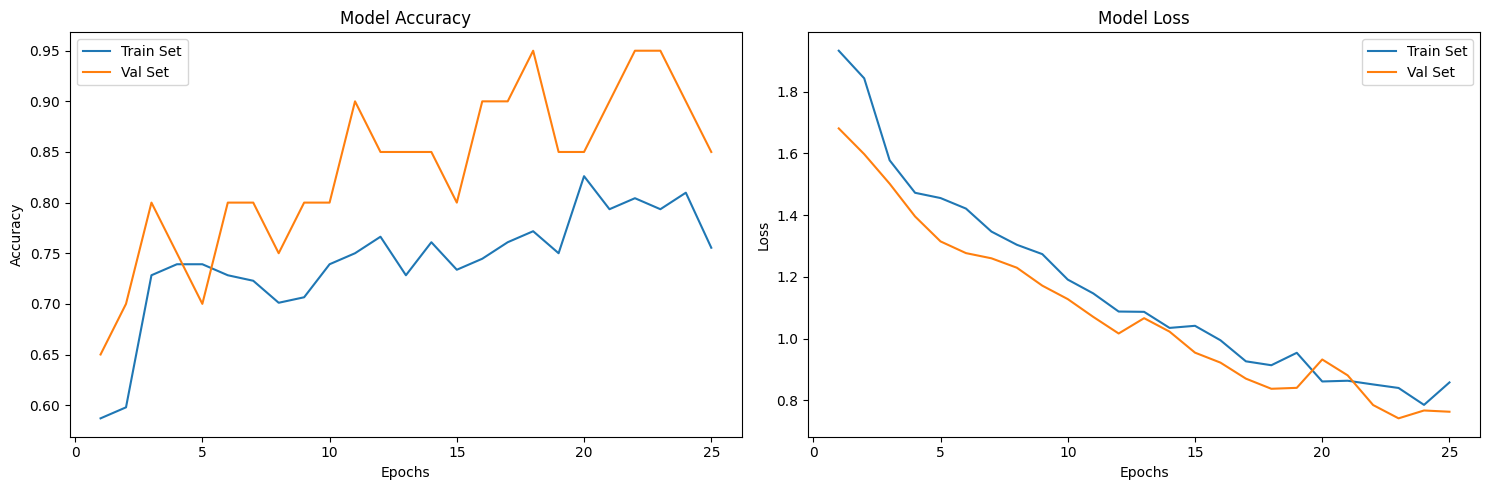

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(1,len(history.epoch)+1)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1 2,2)
plt.plot(epochs_range,loss,label='Train Set')
plt.plot(epochs_range,val_loss,label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


We can see that the validation accuracy increases with epochs and training accurcay increases too.
But we can see that accuracy is not stable with fluactuations. This may be due to very low number of images in my validation set and traning set.

We can also see that the loss decreases in a very stable way in both the validation and the training data.**This indicates that the model is effectively minimizing the error and learning useful patterns from the data.**

This also confirms that fluctuations in accuracy are likely due to data imbalance or low sample size, rather than training instability.

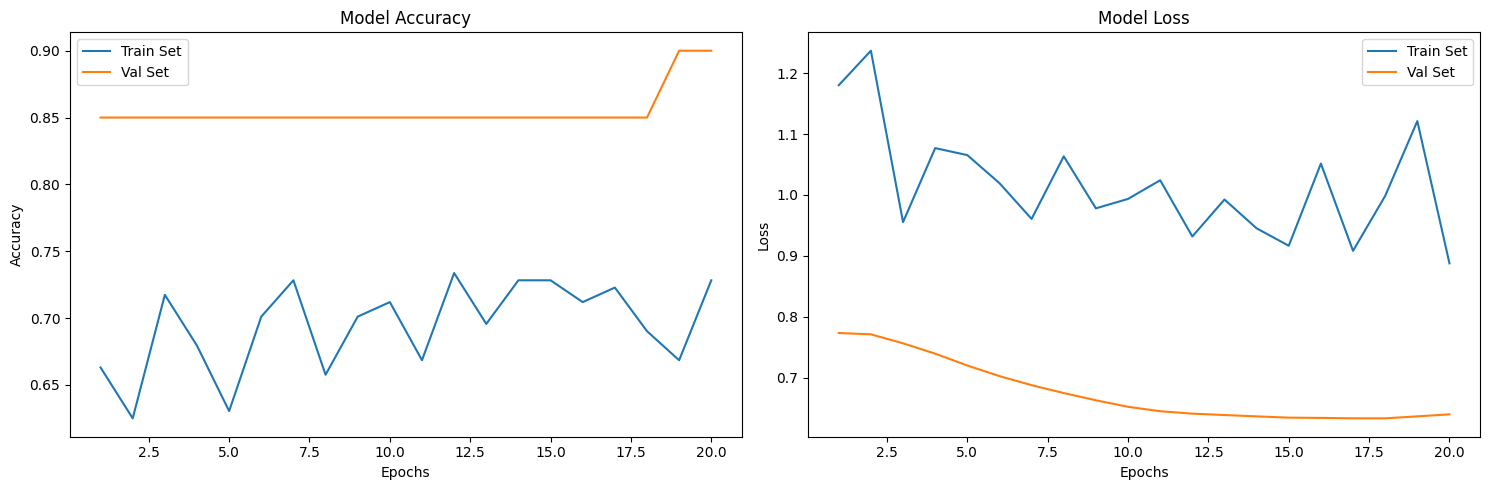

In [ ]:
acc =history_phase2.history['accuracy']
val_acc=history_phase2.history['val_accuracy']
loss=history_phase2.history['loss']
val_loss=history_phase2.history['val_loss']
epochs_range=range(1,len(history_phase2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


In the second step of training that is in the **fine tuning** step we can see that the validation accurcay remains approx same but the traning epoch is fluctuating very much. This can again be due to the low traning data and the low leanring rate.

In [ ]:
test_results=model.evaluate(test_generator)


print(f"Test Loss:{test_results[0]}")
print(f"Test Accuracy:{test_results[1]}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7300 - loss: 0.9280
Tes.t Loss: 0.912189781665802
Test Accuracy: 0.7200000286102295


In [ ]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = (Y_pred >0.5).astype(int)

y_true = test_generator.classes

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
              precision    recall  f1-score   support

           0       0.55      0.32      0.40        19
           1       0.67      0.84      0.74        31

    accuracy                           0.64        50
   macro avg       0.61      0.58      0.57        50
weighted avg       0.62      0.64      0.61        50



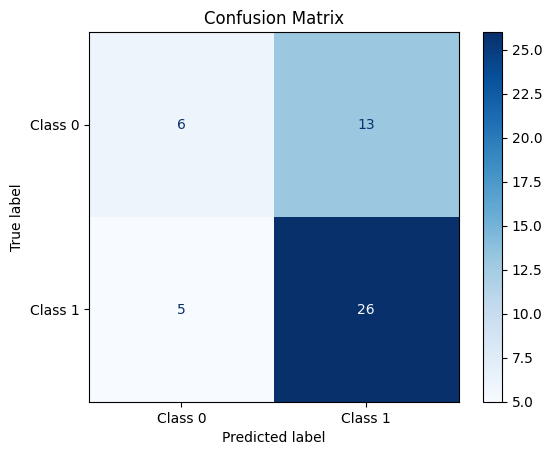

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In the confusion matrix as well as the classification report we are seeign that the model is not performing that good.

We can see that the model is fails to learnt he properteis of the **class 0** that is the minority class even after using class weights.

From this cofusion matrix we get the **TPR(True Postive Rate)=0.83 and FPR(False Positive Rate)=0.68**

In medical imaging tasks like tumor detection:

* **A False Negative (FN) (i.e., saying "No Tumor" when there actually is a tumor) can be dangerous and lead to missed diagnosis.**

*   **A False Positive (FP) (i.e., saying "Tumor" when there is none) is less harmful as it may lead to further examination, which is safer than missing the disease.**

Hence, while our model achieves reasonable sensitivity (TPR), the high False Positive Rate (FPR) is a concern and should be minimized in future iterations.


In [ ]:
model.predict(test_generator).ravel()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


array([0.17670397, 0.45948207, 0.9497998 , 0.39270225, 0.3012427 ,
       0.8604578 , 0.55035305, 0.735326  , 0.70620245, 0.9638121 ,
       0.68142164, 0.8394533 , 0.82051975, 0.9945897 , 0.8045491 ,
       0.93427247, 0.7865869 , 0.82728446, 0.8621501 , 0.97012055,
       0.9700937 , 0.24854888, 0.41181973, 0.96291685, 0.25069317,
       0.2703111 , 0.5083835 , 0.619136  , 0.16926566, 0.9573903 ,
       0.5887024 , 0.78710985, 0.9841155 , 0.48975053, 0.96181023,
       0.5913531 , 0.9373171 , 0.7322323 , 0.94241434, 0.8972785 ,
       0.9706965 , 0.2764772 , 0.79380447, 0.8581579 , 0.81043833,
       0.7186654 , 0.9369141 , 0.99468416, 0.79607236, 0.64605606],
      dtype=float32)

Plotting the **ROC(Reciever Operator Charactericstics)** curve

And calculating the Area Under the RUC curve.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


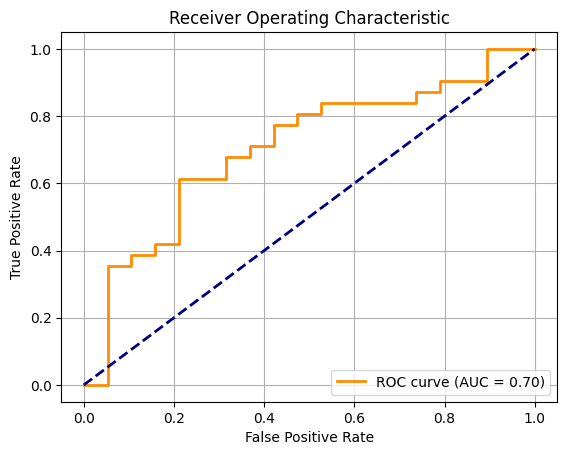

Best threshold 0.81043833


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores=model.predict(test_generator).ravel()
y_true=test_generator.classes
fpr,tpr,thresholds=roc_curve(y_true,y_scores)
roc_auc=auc(fpr,tpr)

plt.figure()
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f"ROC curve(AUC={roc_auc})")
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid()
plt.show()

val=tpr-fpr
best_threshold=thresholds[np.argmax(val)]
print("Best threshold",best_threshold)

**Using the ROC curve we can get the best threhold as 0.8104.**

This means if my model predicts a probability above then I should tell that it is tumor otherwise not.

But this threhold is not maximising the accuracy as the accurcay depends on imbalanced dataset and accurcay is not relaible indicator in cases like the one I have.

**But the best threshold optimizes the False positive and False Negetive errors.**

**But if we want to reduce the number of False negetive errors as it is more important in Medical Models then we need to reduce the threshold.**

In [ ]:
img=image.load_img('/content/test/yes/0.jpg')
img=img.resize((224,224))
img=np.array(img)
img=img/255.0
img=np.expand_dims(img, axis=0)  # shape becomes (1, 224, 224, 3)
pred=model.predict(img)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.77994764]]


In [ ]:
print(train_generator.class_indices)

{'no': 0, 'yes': 1}


In [ ]:
print(pred)

[[0.9399834]]


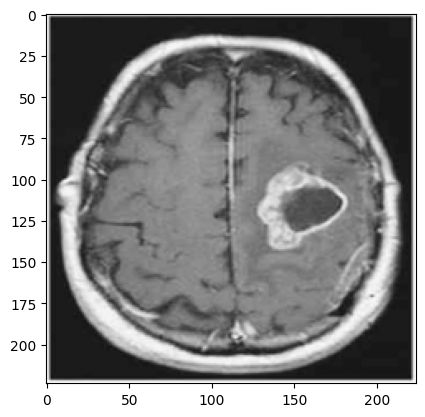

In [ ]:
plt.imshow(img.reshape(224,224,3))

In [ ]:
model.get_weights()

[array([[[[ 2.88208157e-01, -2.73274798e-02,  2.67351419e-02, ...,
           -6.55488670e-02,  5.03475368e-02, -4.56515253e-02],
          [ 1.99836820e-01, -1.79780759e-02, -3.68159488e-02, ...,
            1.49137285e-02, -5.86674325e-02, -9.20280740e-02],
          [ 1.63633555e-01,  2.29261611e-02,  2.22781431e-02, ...,
            3.69511321e-02, -5.65400533e-02, -7.73568973e-02]],
 
         [[ 2.48182908e-01, -1.27168700e-01,  1.82238910e-02, ...,
           -1.47653431e-01,  8.14998075e-02,  6.49594814e-02],
          [ 1.69302464e-01, -6.09455369e-02, -1.79350842e-02, ...,
           -9.85311568e-02,  1.47271249e-02, -1.64240897e-02],
          [ 6.12137169e-02, -2.44877376e-02, -5.26773743e-02, ...,
           -5.27572297e-02, -2.20677052e-02, -9.09108389e-03]],
 
         [[ 3.36220503e-01, -1.08493298e-01,  8.58195052e-02, ...,
           -1.58807382e-01, -3.43158878e-02,  9.48826075e-02],
          [ 1.79538935e-01, -1.01994433e-01,  3.52014962e-04, ...,
           -3.037

#Saliency Maps

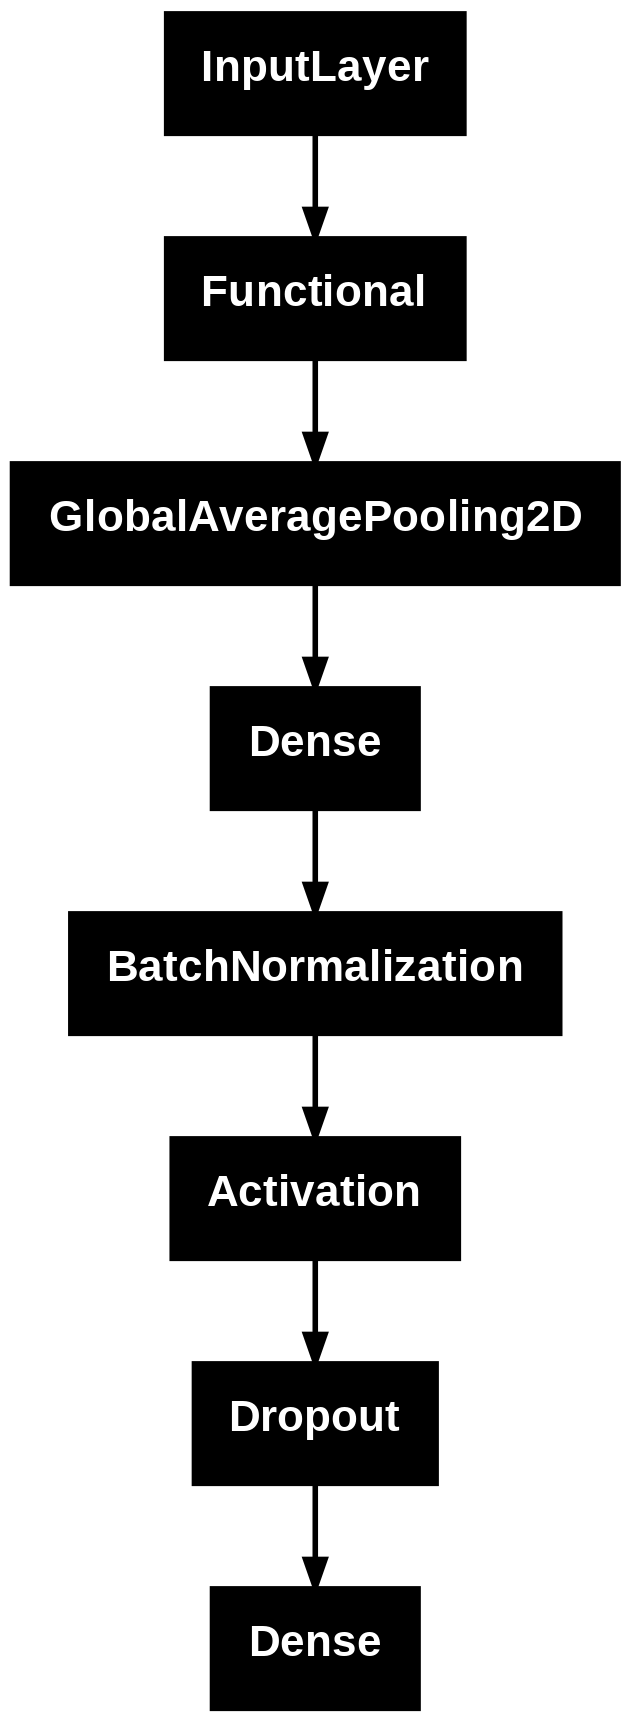

In [ ]:
from keras.utils import plot_model
plot_model(model)

Implementation of the SmoothGrad

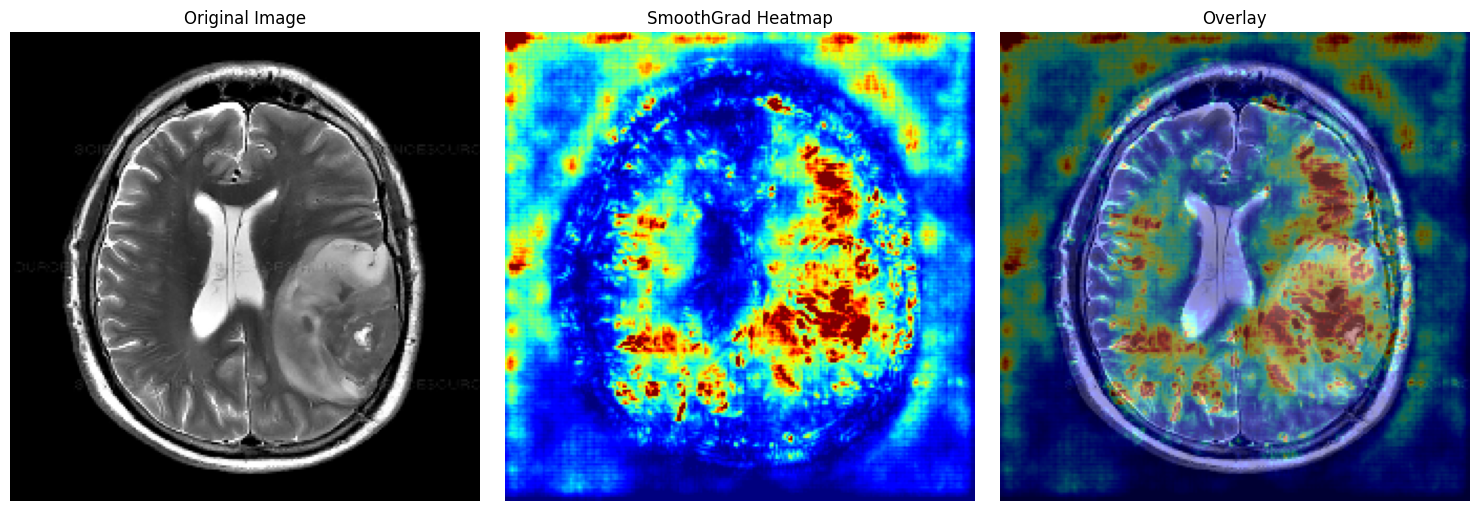

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def compute_smoothgrad_saliency(
    model,img_array,class_index=None,
    noise_level=0.15,num_samples=100,
    seed=42):

    tf.random.set_seed(seed)
    np.random.seed(seed)

    img_tensor=tf.convert_to_tensor(img_array, dtype=tf.float32)
    smooth_grads=[]

    for i in range(num_samples):
         noise = tf.random.normal(shape=img_tensor.shape, stddev=noise_level)
         noisy_img=img_tensor+noise

         with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            preds = model(noisy_img,training=False)

            if class_index is None:
                 if preds.shape[-1] == 1:
                  class_index=0
                else:
                  class_index=np.argmax(preds[0])
            loss=preds[:,class_index]

         grads=tape.gradient(loss,noisy_img)
         saliency=tf.reduce_max(tf.abs(grads),axis=-1)[0]
         smooth_grads.append(saliency.numpy())

    smooth_saliency=np.mean(np.stack(smooth_grads),axis=0)

    smooth_saliency=cv2.GaussianBlur(smooth_saliency, (5, 5), sigmaX=0.5)

    vmin,vmax=np.percentile(smooth_saliency,[2, 98])
    smooth_saliency=np.clip(smooth_saliency,vmin,vmax)
    smooth_saliency=(smooth_saliency-vmin)/(vmax-vmin+1e-8)

    return smooth_saliency

img_path='/content/test/yes/14.jpg'
img=tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array=tf.keras.preprocessing.image.img_to_array(img)
img_array=np.expand_dims(img_array, axis=0)
img_array=img_array/255.0


saliency_map=compute_smoothgrad_saliency(
    model,img_array,
    class_index=0,
    noise_level=0.10,
    num_samples=100,
)


original_im=img_array[0]
overlay=original_img.copy()
heatmap=cv2.applyColorMap(np.uint8(255 * saliency_map), cv2.COLORMAP_JET)
heatmap=cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay_img=cv2.addWeighted(np.uint8(original_img * 255), 0.6, heatmap, 0.4, 0)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SmoothGrad Heatmap")
plt.imshow(saliency_map, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay_img)
plt.axis('off')

plt.tight_layout()
plt.show()


![SmoothGrad output](static/third.png)
Here the model is current able to detect the tumor region.




![SmoothGrad output](static/second.png)
Another instance hwere it can coorectly detect the tumor.




![SmoothGrad output](static/first.jpg)
A clear implication of the model focusing on the tumor correctly.


In [ ]:
model.save('model.h5')